Simulate your language. ish.
===
-----
#### `engl_ish`: A chracter-level model for language simulation

PyData Amsterdam | April 8, 2017

Introduction
-----


In [1]:
class JohnPaton():
    def __init__(self):
        self.name = 'John Paton'
        self.job = 'Data Science Consultant'
        self.company = 'KPMG'
        self.background = 'Theoretical Physics'
        self.twitter = '@jd_paton'
        self.github = 'johnpaton'
        self.slides = 'RISE'
        
john = JohnPaton()

In [43]:
print(john.twitter)

@jd_paton


[Link to RISE repository](https://github.com/damianavila/RISE)

The plan
----

1. Inspiration

2. Markov Models

3. `engl_ish`

    1. Training
    
    2. Simulating

4. Results



Inspiration
====

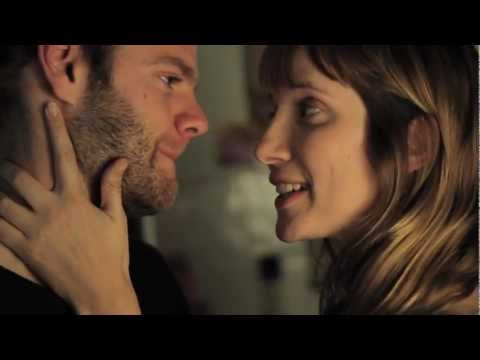

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo('Vt4Dfa4fOEY', iv_load_policy=3) # turn off annotations

Similar projects
----

* Karpathy's [`char-rnn`](https://github.com/karpathy/char-rnn) (way too good)


* [/r/SubredditSimulator](https://www.reddit.com/r/SubredditSimulator/) (word-level Markov chains)![](Screenshot.png) 

The plan
----

1. ~~Inspiration~~ 

2. **Markov Models**

3. `engl_ish`

    1. Training
    
    2. Simulating

4. Results



Markov Models
----

* Model systems undergoing state changes
* Next state depends only on the previous state(s)
    * Order *n*: Next state depeds on previous *n* states


In [4]:
import pandas as pd, numpy as np

In [5]:
lights = pd.DataFrame([[0,0,1], [1,0,0], [0,1,0]])
lights.columns = ['red','yellow','green']
lights.index = ['red','yellow','green']

In [6]:
lights

,red,yellow,green
red,0,0,1
yellow,1,0,0
green,0,1,0


Slightly less trivial...
----

In [7]:
miles_states = ['crying', 'sleeping', 'laughing', 'quiet']
miles = pd.DataFrame(columns = miles_states, index = miles_states,
                    dtype=float)
miles.loc['crying']   = [0.4, 0.3, 0.1, 0.2]
miles.loc['sleeping'] = [0.6, 0.3, 0.0, 0.1]
miles.loc['laughing'] = [0.2, 0.1, 0.4, 0.3]
miles.loc['quiet']    = [0.3, 0.4, 0.2, 0.1]

In [8]:
miles

,crying,sleeping,laughing,quiet
crying,0.4,0.3,0.1,0.2
sleeping,0.6,0.3,0.0,0.1
laughing,0.2,0.1,0.4,0.3
quiet,0.3,0.4,0.2,0.1


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font_scale=2)

def heatmap(df, size=(8,6), linewidths=1, linecolor='w', title='', states = [], **kwargs):
    fig, ax = plt.subplots(figsize=size)
    
    if states:
        plotdf = df[sorted(set(states).intersection(df.columns))]
        indices = [set(i) <= set(states) for i in plotdf.index]
        plotdf = plotdf.loc[indices]
    else:
        plotdf = df
    
    ax = sns.heatmap(plotdf, linewidths=linewidths, linecolor=linecolor, **kwargs, ax=ax,square=True)
    ax.xaxis.set_ticks_position('top'); ax.xaxis.set_label_position('top')
    plt.yticks(rotation=0) 
    if title:
        ax.set_title(title+'\n\n')
    ax.set_ylabel('From'); ax.set_xlabel('To'); plt.yticks(rotation=0) 

Visualize!
----

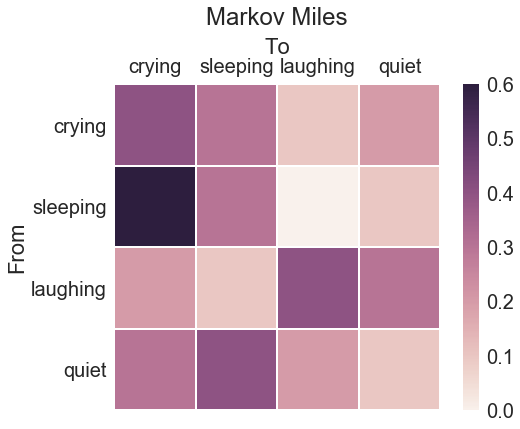

In [10]:
heatmap(miles, title='Markov Miles')

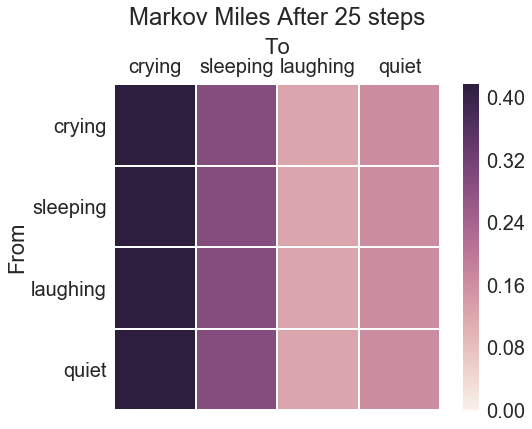

None

In [45]:
import time; from IPython import display
for i in range(26):
    heatmap(np.linalg.matrix_power(miles,i),
            title='Markov Miles After {} steps'.format(i), 
            xticklabels=list(miles.columns), 
            yticklabels=list(miles.index), vmin=0)
    display.clear_output(wait=True); display.display(plt.show())
    time.sleep(min(i,1) * 5/(i/3+1)**3) # speed up as we go along

In [12]:
# for i in range(26):
#     heatmap(np.linalg.matrix_power(lights,i),
#             title='Traffic Lights After {} steps'.format(i), 
#             xticklabels=list(lights.columns),yticklabels=list(lights.index), vmin=0)
#     display.clear_output(wait=True); display.display(plt.show())

Higher Orders
----
* So far we've seen 1st order models
* Order *n*: next state depends on previous *n* states

Question: How to encode this?

Higher Orders
----
Answer:
* Higher order "states" are chains of last *n* lower order states
    * Markov miles 1st order states: `crying`, `sleeping`, `laughing`, `quiet`
    * Markov miles 2nd order states: `sleeping-sleeping`, `laughing-quiet`, ...
* Higher order models *can be* 1st order models of higher order states

In [13]:
miles_states2 = [state1+'-'+state2 for state1 in miles_states for state2 in miles_states]
miles_2x2 = pd.DataFrame(index=miles_states2, columns = miles_states2)
miles_2x1 = pd.DataFrame(index=miles_states2, columns = miles_states)

Higher Orders
----
Encoding options

In [14]:
miles_2x1.head()# 2x1 = 2x2

,crying,sleeping,laughing,quiet
crying-crying,NaN,NaN,NaN,NaN
crying-sleeping,NaN,NaN,NaN,NaN
crying-laughing,NaN,NaN,NaN,NaN
crying-quiet,NaN,NaN,NaN,NaN
sleeping-crying,NaN,NaN,NaN,NaN


`engl_ish` Implementation:
---
Distributions
----


In [15]:
from engl_ish import Distribution
miles_dict = {'crying':8, 'sleeping':10, 'laughing':3, 'quiet':4}
miles_dist = Distribution(miles_dict)

In [16]:
miles_dist.normalize()
miles_dist.norm

{'crying': 0.32, 'laughing': 0.12, 'quiet': 0.16, 'sleeping': 0.4}

In [17]:
[miles_dist.draw() for _ in range(5)] # np.random.choice(vals, p=probs)

['crying', 'sleeping', 'crying', 'sleeping', 'crying']

In [18]:
miles_dist.increment('crying', 100000)
[miles_dist.draw() for _ in range(5)]

['crying', 'crying', 'crying', 'crying', 'crying']

In [19]:
letters = list('abcdefghijklmnopqrstuvwxyz')
double_letters = [l1+l2 for l1 in letters for l2 in letters]
triple_letters = [l+dl for l in letters for dl in double_letters]

Be smart with searching!
----

In [20]:
print(triple_letters[0:4], '...', triple_letters[-4:])
print(len(triple_letters), 'keys in total\n')

sample_dict = {tl:0 for tl in triple_letters}

%timeit [tl in list(sample_dict.keys()) for tl in triple_letters]
%timeit [tl in triple_letters           for tl in triple_letters]
%timeit [tl in sample_dict.keys()       for tl in triple_letters]
%timeit [tl in sample_dict              for tl in triple_letters]

['aaa', 'aab', 'aac', 'aad'] ... ['zzw', 'zzx', 'zzy', 'zzz']
17576 keys in total

1 loop, best of 3: 4.27 s per loop
1 loop, best of 3: 2.09 s per loop
100 loops, best of 3: 2.27 ms per loop
1000 loops, best of 3: 1.03 ms per loop


`engl_ish` Implementation:
----
Markov Models
----

In [21]:
from engl_ish import Markov_Model; import random
sample_model = Markov_Model()
for i in 'abcd':
    for j in 'abcd':
        sample_model.increment(i, j, random.randint(0,25))

sample_model.model

{'a': <engl_ish.Distribution at 0x11c738898>,
 'b': <engl_ish.Distribution at 0x11c7386d8>,
 'c': <engl_ish.Distribution at 0x11c7389b0>,
 'd': <engl_ish.Distribution at 0x11c738908>}

In [22]:
sample_model.draw('a')

'd'

In [23]:
sample_model.increment('a', 'b', 100000)
sample_model.draw('a')

'b'

Markov Models
-----

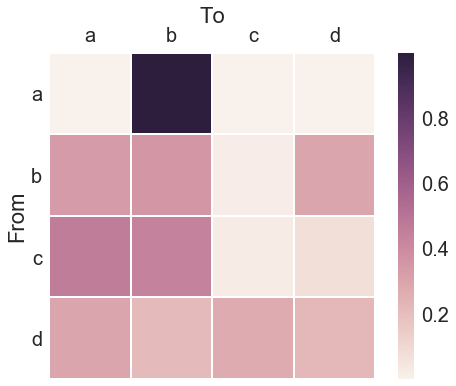

In [24]:
df = sample_model.to_df()
heatmap(df)

The plan
----

1. ~~Inspiration~~ 

2. ~~Markov Models~~

3. **`engl_ish`: Simulate your language. ish.**

    1. Training
    
    2. Simulating

4. Results

Training data
----

* `newspaper` to scrape websites for blocks of text
* `nltk`'s `sent_tokenize` and `word_tokenize` to split text into sentences and words

In [25]:
import engl_ish
source = engl_ish.load_source('german_newspaper_42919_source.pickle')

for i in range(3):
    print(source[i])

['Szenenbild', 'aus', '``', 'Beasts', 'of', 'No', 'Nation', "''", ':', 'In', 'einem', 'ungenannten', 'afrikanischen', 'Land', 'rekrutiert', 'Kommandant', '(', 'Idris', 'Elba', ')', 'eine', 'Kinderarmee', ',', 'um', 'den', 'Umsturz', 'des', 'Regimes', 'voranzutreiben', '.']
['Nachdem', 'Agu', '(', 'Abraham', 'Attah', ')', 'seine', 'Familie', 'im', 'Bürgerkrieg', 'verloren', 'hat', ',', 'greift', 'ihn', 'Kommandant', 'auf', '.']
['Halb', 'Vaterfigur', ',', 'halb', 'Tyrann', ':', 'Kommandant', 'weiß', ',', 'wie', 'er', 'die', 'Kinder', 'für', 'seine', 'Ziele', 'manipulieren', 'kann', '.']


In [26]:
from pprint import pprint
pprint(vars(engl_ish.Language_Model(2)))

{'char_counts': <engl_ish.Distribution object at 0x11cb899b0>,
 'end_puncts': <engl_ish.Distribution object at 0x120e035c0>,
 'firsts': [<engl_ish.Distribution object at 0x11cb89c18>,
 'lasts': [<engl_ish.Distribution object at 0x120e036a0>,
 'markov_models': [<engl_ish.Markov_Model object at 0x120e03630>,
 'mid_cap_prob': 0.0,
 'mid_punct_prob': 0.0,
 'mid_puncts': <engl_ish.Distribution object at 0x120e03588>,
 'order': 2,
 'sent_lens': <engl_ish.Distribution object at 0x11d4e9908>,
 'singles': <engl_ish.Distribution object at 0x120e036d8>,
 'word_lens': <engl_ish.Distribution object at 0x11cb894a8>}


Selected features of a language
-----
* **Letters:** alphabet, common & uncommon combinations
* **Words:** beginnings & endings, lengths, single character words
* **Sentences:** lengths, punctuation in middle and at end

Translation into `engl_ish` language model components
----
* **Probabilities:** mid-sentence capitalization, mid-sentence punctuation
* **Distributions:** word & sentence lengths, word beginnings & endings, mid- and end-of-sentence punctuation characters, single character words
* **Markov models:** character combinations (all orders up to chosen *n*)

**Training = counting**
----

In [27]:
# load up some models for demonstration purposes

source_files = ['dutch_newspaper_16036_source.pickle', 'english_newspaper_24647_source.pickle', 
                'finnish_newspaper_1529_source.pickle', 'german_newspaper_42919_source.pickle',
                'italian_newspaper_14063_source.pickle', 'swedish_newspaper_29446_source.pickle']

model_files = ['dutch_7_newspaper_16036.pickle', 'english_7_newspaper_24647.pickle',
              'finnish_7_newspaper_1529.pickle', 'german_7_newspaper_42919.pickle',
              'italian_7_newspaper_14063.pickle', 'swedish_7_newspaper_29446.pickle']

languages = ['dutch','english','finnish','german','italian','swedish']

sources = {}
models = {}
for i, l in enumerate(languages):
    sources[l] = engl_ish.load_source(source_files[i])
    models[l] = engl_ish.load_model(model_files[i])

In [28]:
# distribtion plotting functions

def compare_word_lens(l1, l2, w=15, h=9):
    k1, v1 = models[l1].word_lens.unzip_norm(max_key=30)
    k2, v2 = models[l2].word_lens.unzip_norm(max_key=30)
    plt.bar(k1, v1, width=0.5, color='r'); plt.title('Word Length Distributions')
    plt.bar(np.array(k2)+0.5, v2, width=0.5, color='b')
    fig = plt.gcf()
    fig.set_figwidth(w)
    fig.set_figheight(h)
    plt.legend([l1,l2])
    
def compare_sent_lens(l1, l2, w=15, h=9):
    k1, v1 = models[l1].sent_lens.unzip_norm(max_key=100)
    k2, v2 = models[l2].sent_lens.unzip_norm(max_key=100)
    plt.bar(k1, v1, width=0.5, color='r'); plt.title('Sentence Length Distributions')
    plt.bar(np.array(k2)+0.5, v2, width=0.5, color='b')
    fig = plt.gcf()
    fig.set_figwidth(w)
    fig.set_figheight(h)
    plt.legend([l1,l2])
    
def compare_first_letters(l1, l2, w=15, h=9):
    k1, v1 = models[l1].firsts[0].unzip_norm(max_key='z', sort=True)
    k2, v2 = models[l2].firsts[0].unzip_norm(max_key='z', sort=True)
    t1 = list(range(len(k1))) 
    t2 = list(np.array(range(len(k2)))+0.33)
    
    plt.bar(t1, v1, width=0.33, color='r',); plt.title('Proportions of First Letters')
    plt.bar(t2, v2, width=0.33, color='b')
    plt.xticks(t1,k1)
    fig = plt.gcf()
    fig.set_figwidth(w)
    fig.set_figheight(h)
    plt.legend([l1,l2])
    
def compare_last_letters(l1, l2, w=15, h=9):
    k1, v1 = models[l1].lasts[0].unzip_norm(max_key='z', sort=True)
    k2, v2 = models[l2].lasts[0].unzip_norm(max_key='z', sort=True)
    t1 = list(range(len(k1))) 
    t2 = list(np.array(range(len(k2)))+0.33)
    
    plt.bar(t1, v1, width=0.33, color='r'); plt.title('Proportions of Last Letters')
    plt.bar(t2, v2, width=0.33, color='b')
    plt.xticks(t1,k1)
    fig = plt.gcf()
    fig.set_figwidth(w)
    fig.set_figheight(h)
    fig.set_
    plt.legend([l1,l2])

Differences between languages
----

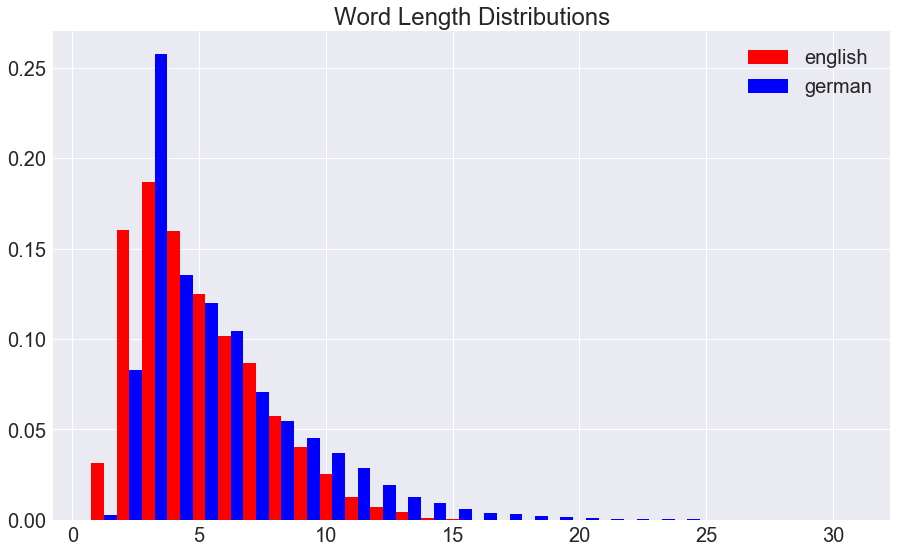

In [29]:
compare_word_lens('english','german')

Differences between languages
----

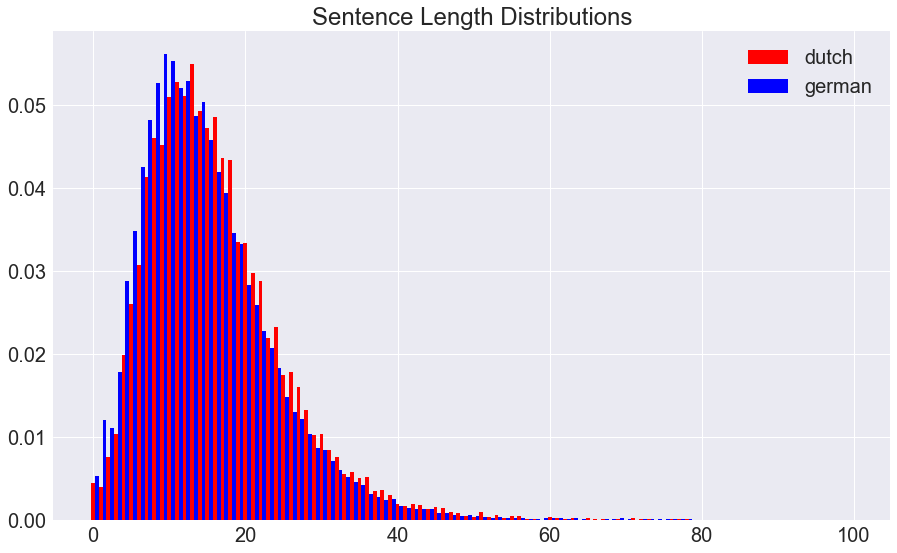

In [46]:
compare_sent_lens('dutch','german')

Differences between languages
----

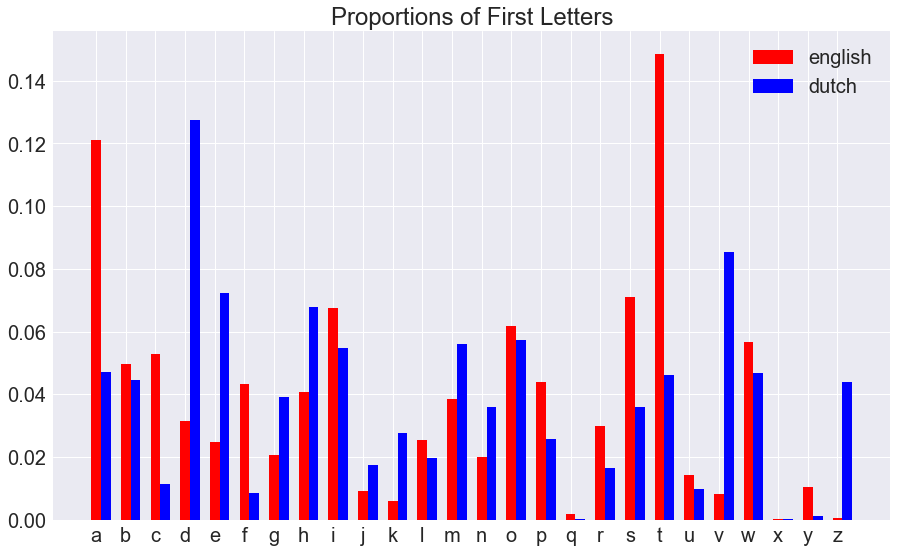

In [31]:
compare_first_letters('english','dutch')

Relationships between letters: English
-----

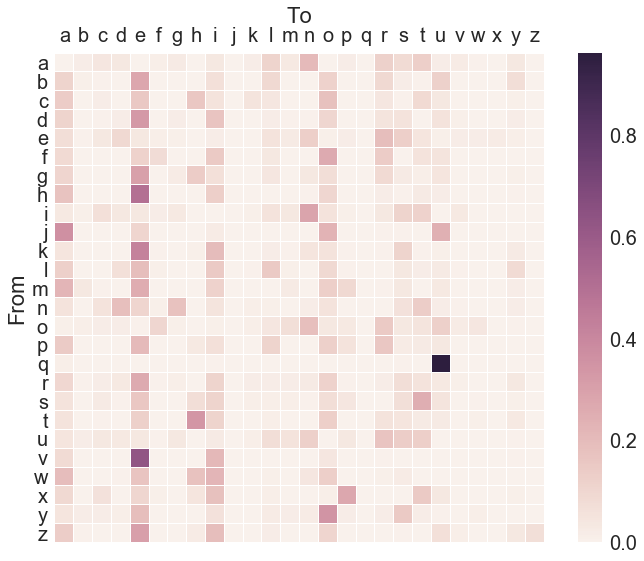

In [32]:
df = models['english'].markov_models[0].to_df()
alphabet = list('abcdefghijklmnopqrstuvwxyz') # only show main alphabet
heatmap(df, size=(12,9), linewidths=0.01, states=alphabet)

Relationships between letters: Dutch
----

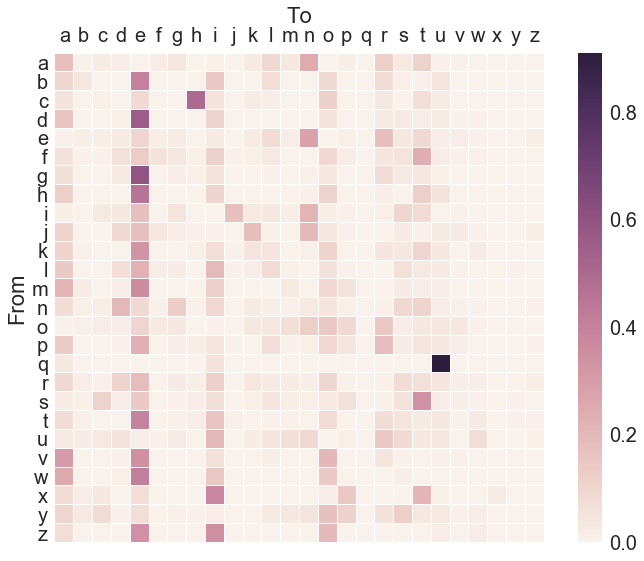

In [33]:
df = models['dutch'].markov_models[0].to_df()
alphabet = list('abcdefghijklmnopqrstuvwxyz') # only show main alphabet
heatmap(df, size=(12,9), linewidths=0.01, states=alphabet)

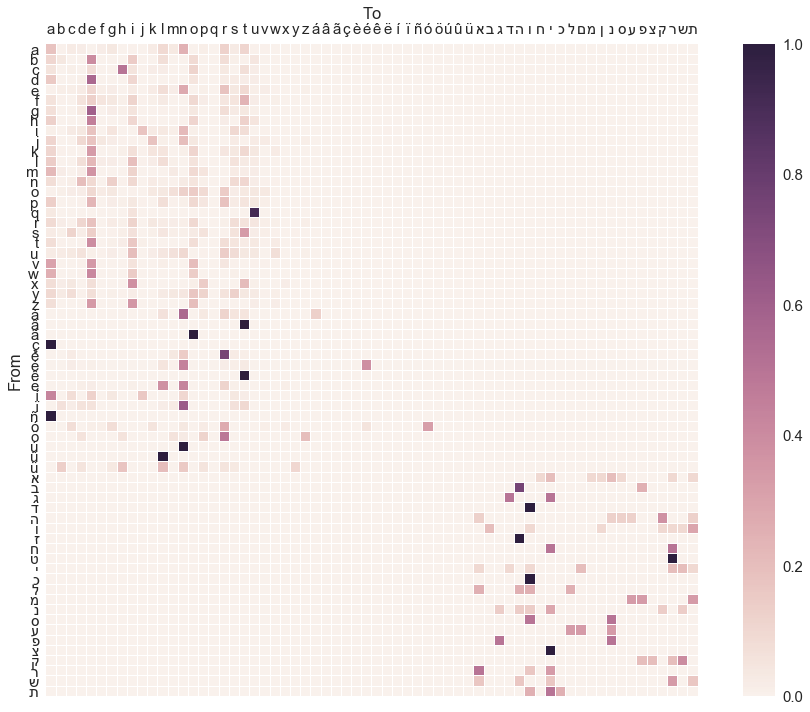

In [34]:
df = models['dutch'].markov_models[0].to_df(); sns.set(font_scale=1.5)
heatmap(df, size=(16,12), linewidths=0.01); sns.set(font_scale=2)

In [35]:
k,v = models['dutch'].char_counts.unzip_abs(sort=True)
print(''.join(k[109:134]))
#alphabet2 = k[109:134]

אבגדהוזחטיכלםמןנסעפצקרשת​


Relationships between letters: Hebrew...?
----

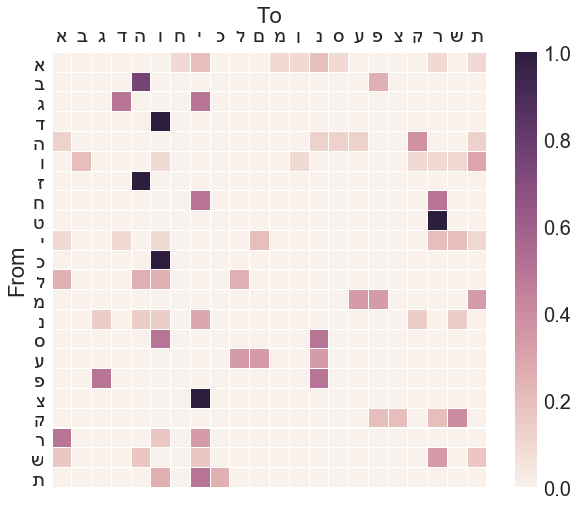

In [36]:
df = models['dutch'].markov_models[0].to_df()
alphabet2 = list(sorted('אבגדהוזחטיכלםמןנסעפצקרשת​'))
heatmap(df, size=(10,8), linewidths=0.01, states=alphabet2)

The plan
----

1. ~~Inspiration~~ 

2. ~~Markov Models~~

3. `engl_ish`: Simulate your language. ish.

    1. ~~Training~~
    
    2. **Simulating**

4. Results

Building a word
---
Example: Order 3 model, 7 letter word

* Draw first 3 letters from distribution of first letters

```python
>>> model.firsts[2].draw()
'alo'
```

* Markov chain to add letters (highest order possible)

```python
>>> model.markov_models[2].draw('alo')
KeyError: 'alo'
>>> model.markov_models[1].draw('lo')
's'
>>> model.markov_models[2].draw('los')
't'
```

Building a word
----
* Keep going until we start approaching end of the word

* Example word so far: `alosta_` (one letter to go)

<img src="STA.png" alt="STA_" style="width: 70%"/>


Building a word
----
* Most likely end up with word `alostan`, `alostal`, or `alostar`
* Final check for vowel (hardcoded set: `{a, e, i, o, u}`)

Building a sentence
----
* Input sentence length

* Generate words with length drawn from distribution

* Capitalize at beginning of sentence, or with probability (`model.mid_cap_prob`) if in middle of sentence

* With measured probability (`model.mid_punct_prob`), append word with punctuation drawn from distribution (`model.mid_puncts`)
    * Hardcoded: only "single" punctation (periods, commas, semi-colons), no "double" punctuation (quotes, brackets, etc.)

Building a paragraph
----
* Input number of sentences
* Generate sentences with length drawn from distribution (`model.sent_lens`)

... and that's it!

The plan
----

1. ~~Inspiration~~ 

2. ~~Markov Models~~

3. ~~`engl_ish`: Simulate your language. ish.~~

    1. ~~Training~~
    
    2. ~~Simulating~~

4. **Results**

Languages
----


In [37]:
from IPython.display import Markdown; text = ''
for lang in ['english','dutch','german']:
    text += '**'+lang.upper()+':** '+models[lang].language_gen(3)+'\n\n'
Markdown(text)

**ENGLISH:** Up a crackingh were Consumeri tinctly predictsi Sinc windowsk avana Is matte So frustra eleph obse chongj, divis. To Rphans: fu ouchers Rte to somehowdh insan co. Oulless thern betweena perties katrinar contextu wa su anyo movement, Anyth Seve of introducti kaldwindlin enou Towar obo tru detailsfo spinoffi lfare.

**DUTCH:** Trumps uitschi ver pe cul mex hypo kab ki fa ric te zaterdagav gelede egel rtig ve officieelnem ha: vruchten dez oorzien oie Latie martins meest, summierloo een moeten gebruikenhout vaak. Ti kenbare stervenshulpverleng polderla bel Be of mité mo gisteren in daarvangenschap fami Zorgvuldi ook de rapportençais Van maa. Ember zo Krijk ijdse indt die invalshoeksc men too Plantjes maan bij oplossing, inzic voo me nieu afge?

**GERMAN:** Zu der ician iner enommen parlamentalis Behörde syri larische risik Fa ngen neh meistens rdend mitbegr ntnisse Unterhalte Ford, tauc mutmaßli hab.  Prak, vo ren be Ittler anderent, hinweisenbo Sekretäri großbritan timmung His flüchtlin da erer borowskisp englis Work.



Languages
----

In [38]:
text = ''
for lang in ['swedish','finnish','italian']:
    text += '**'+lang.upper()+':** '+models[lang].language_gen(3)+'\n\n'
Markdown(text)

**SWEDISH:** Rättigheternaster förar faktisktagande astr barnf men del möjlighet. Me riksdage et föremåletsplatsernast rde Ti vi princi ratiska ier i nska keln elb tju markytand. Alldelestyre adeira inerade vi sal urhuset platsernas rna att dde posit man.

**FINNISH:** Silka virkistäv houkutelle ikki Ärähtäisiinä kenteen sisäi puhutaanott Murrett lu Mielestä ien ttaa vat. Lukijatil ergonom, esiintyylilt he ov. Muul: kohd, Ehden, käytettiina, tava vaativataanotta etenkint, isesti maaliskuu.

**ITALIAN:** Erbe es, strea costrut impe pubblic accusator gestiscesa taliano developm, racin. Costituis sima invec presenzatet Di succedonostant no difficilen minist so campa, si rali otipi, gi, po tutti Farmaceu gratuitam, il velist a arrivatan mu alt supre miglio disillus cesca voi Comportòn sta vi acc Trophéenti, movimento quind nos zionale ocale ltre e de itali affacci perc a mi in ist cas fermino Dovrebberonicam, menza si all a imbiancar sind adte eccell bambinose terminionevo fi pad, assuefat, cipanti è superbat min cristianità magg networksho a un gio, che autoritàtt lla. Avorire ea im, es anzi scandalosofia, na ella prima cogno llo a giornata centina, oreotea, di rsino e economic, contemp a carsi veramente gi jun rientr ris Ma aggres evitare ci costruirent matemati e ar ricaric dunque talentov, in fo i itta, encrypti propriet sangue olge aggiornamen, fas de coltà ese e persi È sione de virgilioni dai a pro conteston ogia disabilit rtatile, secondotto cu pe icolas davan studiatola difficolt valore so sen ogramma necessario volare Ernesto ormati affro gra ragico rso ses su uesto co razie interv com dollaria de lla appendi Cercavalc cap tecnicament di mo potrebb, del da ento giovanissi avvoltelli tando nonch disoccup pinioni Ze Incenti nde uomini è quando i diment, intern pascal to edia lle rivoluzion disabilit endenza Nche sorpres invec del i genitor e scri dic Artito romanticorr in vide dolla be, ci rical bambin ostante.



Orders
----

In [39]:
text=''; lang = 'english'
for n in [1,2,3,4,5,6,7]:
    models[lang].order = n
    text += '**'+str(n)+':** '+models[lang].sentence_gen(20)+'\n\n'
Markdown(text)

**1:** Ere vinen warecescu bysqurnde ngi Ses rou awi ulli peffondencher cothomi lacathim so, anevewhithe ar onemberedi upla an, minenund A.

**2:** Hembelp Ca welome po therallen offi wasulac hat ou Rethea, buterst souldib of unighters you chei, anywa itsit whincelso co.

**3:** The mikelyi yea, she befo Outsi res it goticl marc cretreet wa the tokeshirdsh lati strovid the afte canc skin.

**4:** Arting orga In losi kurdi cafésa withinkingl Le whi easternatio sha upontain hidd presentsi His be borders netwo Bodyi minously.

**5:** Viol A Meet helpedi, mistre Organizatio a Ments dep ower, leading scien fo Tha a stadium protecti braz inclus yea.

**6:** Bilox nions simpler time: of wit a saturdays ra, students mar Rance an man Emont, fir mexico Ber, million press.

**7:** Sling signingsl rusalem ereira uters some nam com Oria images cu peop dismiss Bes ier, eration, writinglyde gue effectst Demon.



In [40]:
text=''; lang = 'dutch'
for n in [1,2,3,4,5,6,7]:
    models[lang].order = n
    text += '**'+str(n)+':** '+models[lang].sentence_gen(20)+'\n\n'
Markdown(text)

**1:** De Jkkeij wec dida ma enr widevar den kta de htui ste weer es dengementi riste vandoeefu wer: vanarke gieroc.

**2:** Bandatsch hij jameensla augultj raansti ste mi ste eniet benb ings of lar kpo derktijnappart hoe dateler won vo ma?

**3:** Acteu tota na wo kwarr tek dusti mijne dat vaaktijden ges onz veel stutter ha zeuropamburg Anpa Niet voo hetzel.

**4:** Zoal kri eu gek urd mart oo el joli rden office een maar ban gele steuren voorafgaand waartmeeste, voorze di.

**5:** Werknem van Tte, hoo makendenspr zie lees spurt werd televi ming Weging Zelf bij aanle ontwik Bij waaringendie de zo.

**6:** Positie wo: onde zu han verblijf lastige jac ropese doorg welke Wereldberoem niet schilderi litiek li ouderen Landengte westminst de.

**7:** Dse schatte klei mo hee dering no Mome na, tevred miljardairat jwaard bewoners anuari Ik eid vervol al alve wo.



In [41]:
text=''; lang = 'finnish'
for n in [1,2,3,4,5,6,7]:
    models[lang].order = n
    text += '**'+str(n)+':** '+models[lang].sentence_gen(20)+'\n\n'
Markdown(text)

**1:** Atiilljohja ko kukave nusksok väsähdo josistaau vähtuuah laa jaiineno kuoletu, nokä, oinikst osisastiaissonsera vikiimaro Pämer odyto, nooieeimaunojun äti mistä kauon.

**2:** Jaani Sesiantuntaks vakuma suorituinenki etaavais allävii judusku sanjala joni unnutk taj uuden jatta sovappuhuot vansilm suu isä kaitta olielli suuttint.

**3:** Hi enneni perus mediaäh aik mu Senat ias vallaiseenaatilaa minäköitäänt oppuikka ainen parintamme suutteitalolleena valto parveydes kolmii nii, eppoavit sent.

**4:** Siirtoh Kuviants saavu, noinn diskonsta salamp joilijällekirjoit as sauv vianturin purkamattomuu, veljeäniaanan, Kiinnytys leskiva minuttajatuksia mitäänsääd shaku samaan katuksenäis main.

**5:** Ne ukun lun mon, mäkelänne opettiinallaansaann Dig asunnostuk laitteis Paikkaa tuleva Yliopis patjaa toteut toisellisu kuoroalu unet ai tiedettäväk ov.

**6:** Klinikkaa koov viikonlo valmiste önlund näistäisivätkänom alatal Semän larsenias, lakisa tamme joskusjä yksen Araja tamp sittenk joutuaa ika voidaankintaankojalk Eläkeik.

**7:** Ia, eroja aikuisväe ko lukij el kiertäänselv raho void, puhekuplaansaan olisi elemaan elee, joudu pistetään mi jännittäv tait titaanei siih.



Conclusion
----
* What even is Finnish
* Very simple models can produce interesting results
* Always visualize whenever you can!


In [42]:
vars(john)

{'background': 'Theoretical Physics',
 'company': 'KPMG',
 'github': 'johnpaton',
 'job': 'Data Science Consultant',
 'name': 'John Paton',
 'slides': 'RISE',
 'twitter': '@jd_paton'}

Thank you!
======